ELEC-E5550 - Statistical Natural Language Processing
# SET 4: POS-tagging

## Released: 9.02.2021 at 17:00
## Deadline: 1.03.2021 at midnight

# Overview

**Part-of-speech tagging** (**POS tagging**) is the process of annotating words in an input sequence with their corresponding part-of-speech labels. Word's **part-of-speech** gives us more information about the word itself and about its neighboring words (nouns are preceded by determiners "a dog" and adjectives "nice dog"). For instance, we can use POS tags as features for the Named Entitity Recognition task: Proper Nouns like names are usually these entities. Moreover, a word's **part-of-speech** provides us with an understanding of how to pronounce this word: cOntent if it is a noun and contEnt if it is an adjective. This helps in such tasks as speech synthesis.

In this assignment we're going to create two systems for assigning POS tags. They are both based on statistics collected from a corpus annotated with POS tags by humans. First, we will be assigning words the most frequent tag it has been seen with. This is a **baseline** we will be trying to beat. Second, we will create a **Hidden Markov Model** **HMM** system and compare its performance to our baseline. The POS tagging algorithm is judged by how **accurate** it is. So we are going to use **accuracy** as the performance metric.

For this assignment we will be using [the GUM corpus](https://corpling.uis.georgetown.edu/gum/) annotated with [Universal Dependencies POS tags](https://universaldependencies.org/u/pos/). We recomend to study the tags, to understand what each of them means.

* `/coursedata/04-pos-tagging/tags_vocab.txt` - vocabulary of UD tags sorted in alphabetical order
* `/coursedata/04-pos-tagging/train.txt` - corpus for training (4219 sentences, 12181 tokens)
* `/coursedata/04-pos-tagging/words_vocab.txt` - vocabulary of the training corpus sorted in alphabetical order (all word types in the training corpus)
* `/coursedata/04-pos-tagging/test_words.txt` - unlabelled test corpus (1055 sentences, 5262 tokens)
* `/coursedata/04-pos-tagging/test_tags.txt` - correct tags for test corpus

# Table of contents
* [Task 1: Reading the data](#task_1)
    * [Step 1.1: Read the vocabularies](#subtask_1_1)
    * [Step 1.2: Read the train corpus](#subtask_1_2)
    * [Step 1.3: Read the test corpus](#subtask_1_3)
* [Task 2: Study the data](#task_2)
    * [Step 2.1: Collect word-to-tag statistics](#subtask_2_1)
    * [Step 2.2: Study words and their possible tags / tags and their possible words](#subtask_2_2)
    * [Step 2.3: Collect tag-to-tag transition statistics](#subtask_2_3)
    * [Step 2.4: Study tag to tag transitions](#subtask_2_4)
* [Task 3: Baseline creation](#task_3)
    * [Step 3.1: Create a baseline](#subtask_3_1)
    * [Step 3.2: Evaluate accuracy](#subtask_3_2)
    * [Step 3.2: Study the baseline results](#subtask_3_3)
* [Task 4: HMM POS-tagger](#task_4)
    * [Step 4.1: Create Viterbi algorithm ](#subtask_4_1)
        * [Step 4.1.1: First column of V](#subtask_4_1_1)
        * [Step 4.1.2: The rest of V and P](#subtask_4_1_2)
        * [Step 4.1.3: Traceback the Tag sequence](#subtask_4_1_3)
    * [Step 4.2: Compare HMM and Baseline](#subtask_4_2)
* [Checklist before submission](#checklist)

## TASK 1 <a class="anchor" id="task_1"></a>
## Read the data

In this assignment we are lucky to get already pre-processed text. However, be careful with pre-processing your text for POS tagging: your pre-processing steps should match the pre-processing of the corpus you're collecting statistics from. For example, *POS* tag (Possessive ending) employed in [Penn Treebank Project](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) is only used for tokens *'s*, do you need your tokenizer to separate them first.

Hopefully, by now it will be easy for you to read three types of text files.

## 1.1 <a class="anchor" id="subtask_1_1"></a>
### Read the vocabularies (1 point)

The files for word and tag vocabularies contain each vocabulary member on its own line. Write a function to collect these vocabularies as lists.

In [1]:
def read_vocab(file_name):
    """ Reads a vocabulary from a .txt file into a list of strings
    
    
    Parameters
    ----------
    file_name : str
        a path to a vocabulary file
    
    Returns
    -------
    vocab : a list of strings
        a list of vocabulary words from a .txt file
        the elements of the vocabulary should have the same order as in the file
    """
    
    # YOUR CODE HERE
    with open(file_name) as f:
        data=f.read()
        f.close()
    vocab=data.split('\n')
    
    return vocab

In [2]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
dummy_vocab_path = "/coursedata/04-pos-tagging/dummy_vocab.txt"

# check that the output of the function is a list
assert_equal(type(read_vocab(dummy_vocab_path)), list)
# check that it's a list of strings
assert_equal(type(read_vocab(dummy_vocab_path)[0]), str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
correct_dummy_vocab = ['this', 'is', 'a', 'dummy', 'voabulary', '!']
assert_equal(read_vocab(dummy_vocab_path), correct_dummy_vocab)

# SANITY CHECK FOR THE NOTEBOOK DATA
# check that the length is right
assert_equal(len(read_vocab('/coursedata/04-pos-tagging/tags_vocab.txt')), 17)
assert_equal(len(read_vocab('/coursedata/04-pos-tagging/words_vocab.txt')), 12181)
# check that the order is correct
assert_equal(read_vocab('/coursedata/04-pos-tagging/tags_vocab.txt')[12], 'PUNCT')
assert_equal(read_vocab('/coursedata/04-pos-tagging/words_vocab.txt')[303], '213')



## 1.2 <a class="anchor" id="subtask_1_2"></a>
### Read the training corpus (1 point)

The training corpus contains 4219 sentences with words labeled with their correct POS tags by humans. Each sentence is located on its own line, the words are separated from each other by whitespaces. The word is separated from its tag like this: Word_/_TAG. 

Your task is to write a function that creates a list of sentences. Each sentence is, in turn, a list of tuples, where the first element is a word and the second element is its tag.

In [3]:
def read_train(file_name):
    """ Read the training corpus of POS-tagging
    
    this function takes in a path to a training corpus file, reads the file,
    and returns a list of sentences. each sentence is, in turn, a list of tuples, 
    where the first element is a word and the second element is its tag
    
    Parameters
    ----------
    file_name - string
        a path to a file with an annotated corpus
    
    Returns 
    -------
    words_and_tags - a list of lists of tuples
        For example, the first sentence ina file is 'word1_/_tag word2_/_tag' 
        and the next sentence in 'word3_/_tag'. Then you should get:
        [[('word1','tag'),('word2', 'tag')],[('word3','tag')]]
    """
    
    # YOUR CODE HERE
    with open(file_name) as f:
        data=[sentence.rstrip() for sentence in f]
        f.close()
    words_and_tags=[]
    for sentence in data:
        word_tag_tuple=[]
        word_tag_pairs=sentence.split(' ')
        for word_tag_pair in word_tag_pairs:
            word,pair=word_tag_pair.split('_/_')
            word_tag_tuple.append((word,pair))
        words_and_tags.append(word_tag_tuple)
    return words_and_tags

In [4]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
dummy_train_path = "/coursedata/04-pos-tagging/dummy_train.txt"

# check that the output of the function is a list
assert_equal(type(read_train(dummy_train_path)), list)
# check that it's a list of lists
assert_equal(type(read_train(dummy_train_path)[0]), list)
# check that it's a list of lists of tuples
assert_equal(type(read_train(dummy_train_path)[0][0]), tuple)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
correct_dummy_train = [[('word1', 'TAG1'), ('word2', 'TAG2')],
                       [('word3', 'TAG3'), ('word4', 'TAG4')]]

assert_equal(read_train(dummy_train_path), correct_dummy_train)

# SANITY CHECK FOR THE NOTEBOOK DATA
assert_equal(len(read_train("/coursedata/04-pos-tagging/train.txt")), 4219)


## 1.3 <a class="anchor" id="subtask_1_2"></a>
### Read the test corpus (1 point)
The test corpus is located in two separate files. One contains 1055 unlabeled test sentences. Each sentence is located on its own line. Another file contains corresponding 1055 sequences of tags. Each tag sequence is located on its own line. Both words and tags are separated from each other by whitespaces.

The purpose of the separation is to compare how our systems differ from the original tag sequene, and what system is closer to the true labels.

In [5]:
def read_test(file_name):
    """ Reads test subcorpus
    
    this function takes in a path to a test corpus file, reads the file,
    and returns it as a list of sentences. each sentence is a list of words or a list of tags.
    
    Parameters
    ----------
    file_name : string
        a path to a part of a test corpus
    
    Returns
    -------
    test_sents : a list of lists
        lists of sentences of tags or words
        for example, if a first sentence is 'A B', 
        and the second sentence is 'C', then you get:
        [['A','B'],['C']]
    """
    
    # YOUR CODE HERE
    with open(file_name) as f:
        test_sents=[sentence.rstrip().split(' ') for sentence in f]
        f.close()
    return test_sents

In [6]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
dummy_test_path = "/coursedata/04-pos-tagging/dummy_test.txt"

# check that the output of the function is a list
assert_equal(type(read_test(dummy_test_path)), list)
# check that it's a list of lists
assert_equal(type(read_test(dummy_test_path)[0]), list)
# check that it's a list of lists of strings
assert_equal(type(read_test(dummy_test_path)[0][0]), str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
correct_dummy_test = [['A', 'B', 'C'], ['D', 'E', 'F', 'G']]

assert_equal(read_test(dummy_test_path), correct_dummy_test)

# SANITY CHECK FOR THE NOTEBOOK DATA
# check that the number of sentences is right
assert_equal(len(read_test("/coursedata/04-pos-tagging/test_words.txt")), 1055)
assert_equal(len(read_test("/coursedata/04-pos-tagging/test_tags.txt")), 1055)
# check that the length of a first sentence is correct
assert_equal(len(read_test("/coursedata/04-pos-tagging/test_words.txt")[0]), 19)
assert_equal(len(read_test("/coursedata/04-pos-tagging/test_tags.txt")[0]), 19)


### Load the data
Load all of our data parts by running the cell below.

In [7]:
# the list of tag types
tags_vocab = read_vocab("/coursedata/04-pos-tagging/tags_vocab.txt")
# the list of all the word types present in the train corpus
words_vocab = read_vocab("/coursedata/04-pos-tagging/words_vocab.txt")

# the train corpus
words_and_tags = read_train('/coursedata/04-pos-tagging/train.txt')

# the sentences of test set with words as their tokens
test_words = read_test("/coursedata/04-pos-tagging/test_words.txt")
# the sentences of test set with tags as their tokens
test_tags = read_test("/coursedata/04-pos-tagging/test_tags.txt")

## TASK 2 <a class="anchor" id="task_2"></a>
## Study the data

It is always good to look closely at your data. In this task we're going to study things like: how many word types are ambiguous (can have more than one tag), what the most popular POS in English is, what POS is most likely to start a sentence. 

## 2.1 <a class="anchor" id="subtask_2_1"></a>
### Collect word to tag statistics (1 point)
We've already done this type of thing before when we were creating term-document matrices. It is the same system of storing statistical information, but this time it is a word-tag matrix.

Using our training corpus, create a matrix, where rows are words and columns are tags. The cells of this matrix are the number of times a word was seen with some particular tag.

For example, imagine that our training corpus looks like this:

<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/corpus.png">

Then, our word to tag matrix will be as follows:

<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/wt.png">

In [8]:
import numpy as np

def create_word_tag_matrix(training_corpus, vocab_words, vocab_tags):
    """ Creates word-tag co-occurance matrix
    
    this function takes in a training_corpus, its word and tag vocabularies,
    and creates a word-tag count matrix. if some word has never been seen together with a tag,
    their cell should be zero. the order of rows and columns should stay as given in vocabularies.
    
    Parameters
    ----------
    training_corpus : a list of lists
        training corpus as list of sentences with tuples of words and their tags
        [[('word1','tag'),('word2', 'tag')],[('word3','tag')]]
    vocab_words : a list of strings
        lost of word types in the training corpus
    vocab_tags : 
        a list of possible UD tag labels
    
    Returns
    -------
    wt_matrix - a numpy array 
        a matrix containg word to tag counts 
        the matrix has shape (len(vocab_words) X len(vocab_tags))
    """
    
    wt_matrix = np.zeros((len(vocab_words), len(vocab_tags)))
    
    # YOUR CODE HERE
    for sentence in training_corpus:
        for word_tag_pair in sentence:
            index_word=vocab_words.index(word_tag_pair[0])
            index_tag=vocab_tags.index(word_tag_pair[1])
            wt_matrix[index_word][index_tag]+=1
    return wt_matrix.astype(int)

In [9]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal
from numpy.testing import assert_almost_equal

dummy_train = [[('word1', 'TAG1'), ('word2', 'TAG2')],
               [('word3', 'TAG2'), ('word4', 'TAG2'), ('word2', 'TAG1')]]
dummy_word_vocabulary = ['word1','word2','word3','word4']
dummy_tag_vocabulary = ['TAG1','TAG2']

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(create_word_tag_matrix(dummy_train, 
                                          dummy_word_vocabulary,
                                          dummy_tag_vocabulary).shape, (4,2))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
correct_wt_dummy_matrix = np.array([[1., 0.],
                                    [1., 1.],
                                    [0., 1.],
                                    [0., 1.]])
                                   
assert_array_equal(create_word_tag_matrix(dummy_train, 
                                          dummy_word_vocabulary,
                                          dummy_tag_vocabulary), correct_wt_dummy_matrix)


# SANITY CHECK FOR THE NOTEBOOK DATA
# checking the shape
assert_equal(create_word_tag_matrix(words_and_tags, 
                                    words_vocab,
                                    tags_vocab).shape, (12181, 17))
# checkingt he contents


assert_equal(create_word_tag_matrix(words_and_tags, 
                                    words_vocab,
                                    tags_vocab)[0][12], 75)



### create the word-tag matrix
Run the cell below to collect the statistics

In [10]:
wt_matrix = create_word_tag_matrix(words_and_tags, words_vocab, tags_vocab)

## 2.2  <a class="anchor" id="subtask_2_2"></a>
###  Study words and their possible tags / tags and their possible words (3 points)
Word classes (POS) differ from each other. Some are very easy to label because they don't have a lot of words in them. For example, pronouns ('me','you','he'...). Classes like this are called 'closed' because there are no new words coming into them. Classes like nouns are called 'open' because they contain an unlimited amount of words and new words are coming into them all the time. Some words might belong to several classes simulateously. For example, 'close' can be a ver as in 'Close the door' or an adjective as in 'my close friend'. Words like this are called 'ambigous' because we're not sure what class out of several possible to assign them to.

Looking at the matrix we've created, answer the following question:
1. What is the most frequent tag?
2. What tag was given to the smallest number of different word TYPES? 
3. What is the maximum number of different tag TYPES one word TYPE in the training corpus has?
4. What is the word type with the maximum number of different tag TYPES?
5. How many words are ambiguous (words having more than only one tag TYPE)?
6. What is the proportion of unambiguous word TYPES in the vocabulary (how many word types out all word types have only one tag in the train corpus)?

You can create a new cell to do the calculations if needed.

In [11]:
most_popular=tags_vocab[np.argmax(np.sum(wt_matrix,axis=0))]
print(most_popular)
# 2.
least_popular=tags_vocab[np.argmin(np.count_nonzero(wt_matrix,axis=0))]
print(least_popular)
# 3.
max_tag=np.max(np.count_nonzero(wt_matrix,axis=1))
print(max_tag)
# 4.
ambiguos_word=words_vocab[np.argmax(np.count_nonzero(wt_matrix,axis=1))]
print(ambiguos_word)
# 5.
number_of_ambiguos=np.sum(np.count_nonzero(wt_matrix,axis=1)!=1)
print(number_of_ambiguos)
# 6.
p=(len(words_vocab)-number_of_ambiguos)/len(words_vocab)
print(p)

NOUN
PART
6
like
960
0.9211887365569329


In [12]:
# QUESTION 1
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# most_popular_tag = "ADJ"
most_popular_tag = "NOUN"

# QUESTION 2
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# least_open_tag = "ADJ"
least_open_tag = "PART"

# QUESTION 3
# type in the answer as an integer.
# For example:
# max_n_of_different_tags = 2
max_n_of_different_tags = 6

# QUESTION 4
# type in the answer as a string. it should be written exactly as in the word vocabulary.
# For example:
# most_ambiguos_word = "."
most_ambiguos_word = "like"

# QUESTION 5
# type in the answer as an integer.
# For example:
# n_of_unambiguous_words = 200
n_of_ambiguous_words = 960

# QUESTION 6
# type in the answer as a float number from 0 to 1.
# For example:
# part_of_unambiguous_words = 0.2
part_of_unambiguous_words_in_vocab = 0.921

In [13]:
# QUESTION 1 tests

# checks if your answer is a string
assert_equal(type(most_popular_tag), str)


In [14]:
# QUESTION 2 tests

# checks if your answer is a string
assert_equal(type(least_open_tag), str)


In [15]:
# QUESTION 3 tests

# checks if your answer is an int
assert_equal(type(max_n_of_different_tags), int)
# check that it is remotely correct
assert(max_n_of_different_tags in range(3,11))


In [16]:
# QUESTION 4 tests

# checks if your answer is a string
assert_equal(type(most_ambiguos_word), str)


In [17]:
# QUESTION 5 tests

# checks if your answer is an int
assert_equal(type(n_of_ambiguous_words), int)
# checks if it is remotely correct
assert(n_of_ambiguous_words in range (800,1000))


In [18]:
# QUESTION 6 tests

# checks if your answer is a float
assert_equal(type(part_of_unambiguous_words_in_vocab), float)
# checks if it is remotely correct
assert(part_of_unambiguous_words_in_vocab >= 0.8)


## 2.3  <a class="anchor" id="subtask_2_3"></a>
### Collect tag-to-tag transition statistics (3 points)

Another thing we can easily do with our data is creating a bi-gram language model for tags! We will represent it as a tag-to-tag transition matrix. 

As you remember from our language modelling assignment, we also want information about what tag starts a sentence and what tag ends it, so we will need to modify our tag sequences by appending special start-of-sentence **&lt;s>** and end-of-sentence **&lt;/s>** symbols.

Create a tag-to-tag transition matrix to capture this information. The first row of the matrix will correspond to the start symbol, other rows are just tags in their alphabetical order. The columns of the matrix are, again, tags in their alphabetical order, and the last column is an end of sentence tag. Each cell corresponds to the number of times a column tag was seen after a row tag in our training corpus.

For our toy corpus this matrix will look this way:
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/tt.png">
We can see, for example, that only NOUNS can end sentences according to out toy corous. Here is the corpus again, so that it is easy to check that the tag-to-tag matrix makes sense.
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/corpus.png">

In [19]:
def create_tag_to_tag_transition_matrix(training_corpus, vocab_tags):
    """ Creates tag-to-tag transition matrix
    
    this function takes in a training corpus and its tag vocabulary,
    and returns a tag_to_tag_transition_matrix of size [len(tag_vocabulary)+1 X len(tag_vocabulary)+1]
    the cells contain the counts of how many times a row tag was followed by a column tag
    the first row contains the number of times each tag started a sentence
    the last column contains the number of times each tag enedd a sentence
    tags should be in the same order as they were in the vocabulary file
    
    
    Parameters
    ----------
    training_corpus : a list of lists
        [[('word1','tag'),('word2', 'tag')],[('word3','tag')]]
    vocab_tags - a list of strings 
        UD tags
    
    Returns
    -------
    tag_transition_matrix : an numpy array of shape [len(tag_vocabulary)+1 X len(tag_vocabulary)+1]
        contains tag to tag transition statistics
    """
    tag_transition_matrix = np.zeros((len(vocab_tags)+1, len(vocab_tags)+1))

    # YOUR CODE HERE
    for sentence in training_corpus:
        for i,word_tag_pair in enumerate(sentence):
            row_index=vocab_tags.index(word_tag_pair[1])+1
            if i ==0:
                tag_transition_matrix[i][vocab_tags.index(word_tag_pair[1])]+=1    
            if i==len(sentence)-1:
                tag_transition_matrix[row_index][-1]+=1
                break;
            column_index=vocab_tags.index(sentence[i+1][1])
            tag_transition_matrix[row_index][column_index]+=1
    return tag_transition_matrix.astype(int)

In [20]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

dummy_train2 = [[('word1', 'TAG1'), ('word2', 'TAG2')],
               [('word3', 'TAG1'), ('word4', 'TAG2'), ('word2', 'TAG1')]]

dummy_tag_vocabulary = ['TAG1','TAG2']

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check the shape of the matrix
assert_equal(create_tag_to_tag_transition_matrix(dummy_train2, dummy_tag_vocabulary).shape, (3,3))

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
correct_tt_dummy_matrix = np.array([[2, 0, 0],
                                    [0, 2, 1],
                                    [1, 0, 1]])
                                   
assert_array_equal(create_tag_to_tag_transition_matrix(dummy_train2,dummy_tag_vocabulary), correct_tt_dummy_matrix)


# SANITY CHECK FOR THE NOTEBOOK DATA
# check the shape
assert_equal(create_tag_to_tag_transition_matrix(words_and_tags, tags_vocab).shape, (18,18))
# check the contents
assert_equal(create_tag_to_tag_transition_matrix(words_and_tags, tags_vocab)[0][0], 153)



### create and display the tag-to-tag transition matrix 
run the cell below to collect the transition counts and to display them.

In [21]:
tt_matrix = create_tag_to_tag_transition_matrix(words_and_tags, tags_vocab)


import pandas as pd
df = pd.DataFrame(data=tt_matrix, index=["START"]+tags_vocab, columns=tags_vocab+["END"])
df

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,END
START,153,356,282,62,83,507,30,354,69,18,914,467,201,281,0,415,27,0
ADJ,325,372,39,12,203,15,0,3343,41,129,39,125,512,78,2,56,4,5
ADP,676,153,101,8,53,3017,0,1511,401,11,850,1101,183,42,4,86,9,12
ADV,434,379,255,76,62,137,0,53,91,38,137,12,533,92,4,630,2,7
AUX,367,77,485,249,9,375,1,60,33,387,152,33,44,16,0,1349,0,0
CCONJ,294,129,215,74,1,230,0,506,60,24,281,215,44,49,4,485,2,0
DET,1646,0,117,1,0,1,0,3890,89,0,5,731,51,0,3,132,6,0
INTJ,0,2,0,1,0,0,7,0,1,0,7,2,62,0,0,2,0,0
NOUN,151,3509,306,993,1005,78,0,1441,68,413,460,154,4326,370,21,1041,7,187
NUM,46,174,15,9,47,8,0,479,29,7,24,55,619,7,17,29,0,44


## 2.4 <a class="anchor" id="subtask_2_4"></a>
###  Study tag to tag transitions (3 points)

Looking at the tag-to-tag transition matrix we've created, answer the following question:
1. What is the most popular tag bi-gram? 
2. What tag is most likely to follow the adjective tag?
3. What tag is most likely to precede  interjection?
4. What tag is most likely to start a sentence?
5. What tag is most likely to end a sentence?
6. How many tags can never end a sentence according to our training data?

In [22]:
# 1.
bi_gram=df.stack().index[np.argmax(tt_matrix)]
print(bi_gram)
# 2.


('NOUN', 'PUNCT')


In [23]:
#QUESTION 1
# type in the answer as a tuple containing two strings. write tags exactly as in the tag vocabulary.
# For example:
# most_popular_tag_bi_gram = ('ADJ', 'ADJ')
most_popular_tag_bi_gram = ('NOUN', 'PUNCT')

#QUESTION 2
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# tag_after_adj = 'ADJ'
tag_after_adj = "NOUN"

#QUESTION 3
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# tag_before_intj = 'ADJ'
tag_before_intj = "PUNCT"

#QUESTION 4
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# start_tag = 'ADJ'
start_tag = "PRON"

#QUESTION 5
# type in the answer as a string. it should be written exactly as in the tag vocabulary.
# For example:
# end_tag = 'ADJ'
end_tag = "PUNCT"

#QUESTION 6
# type in the answer as an integer number.
# For example:
# n_of_non_final_tags = 15
n_of_non_final_tags = 8



In [24]:
# QUESTION 1 tests

# checks if your answer is a tuple of strings
assert_equal(type(most_popular_tag_bi_gram), tuple)
assert_equal(type(most_popular_tag_bi_gram[0]), str)


In [25]:
# QUESTION 2 tests

# checks if your answer is a string
assert_equal(type(tag_after_adj), str)


In [26]:
# QUESTION 3 tests

# checks if your answer is a string
assert_equal(type(tag_before_intj), str)


In [27]:
# QUESTION 4 tests

# checks if your answer is a string
assert_equal(type(start_tag), str)


In [28]:
# QUESTION 5 tests

# checks if your answer is a string
assert_equal(type(end_tag), str)


In [29]:
# QUESTION 6 tests

# checks if your answer is an int
assert_equal(type(n_of_non_final_tags), int)


## TASK 3 <a class="anchor" id="task_3"></a>
## Baseline creation

## 3.1 <a class="anchor" id="subtask_3_1"></a>
### Create a baseline (1 point)


To understand if our tagger is any good we will need to compare it to some baseline model. One popular approach is to assign each word a tag that it has been labeled the most times with in the trainin data.

Create a function, that labels test word sequences with the most frequent tags for the words. If some word has several tags with the same frequency, just select the one that comes first alphabetically. Assign the word unseen in the training corpus with the 'X' tag. Note, that 'X' tag is not something we've just come up with. It is used in the training corpus. And you can read about it [here](https://universaldependencies.org/u/pos/X.html). 

In [30]:
def baseline(word_tag_matrix , test_words, vocab_words, vocab_tags):
    """ Tags words in a test corpus with the most frequent tag
    
    this function takes in word to tag matrix, test sentences to label, word and tag vocabularies, 
    and assigns every word in test sentences the most frequent tag it was seen with in the training corpus.
    mark a word with "X" tag if it was absent in the training corpus.
    
    Parameters
    ----------
    word_tag_matrix : a numpy array 
        contains word to tag statistics [len(vocab_words) X len(vocab_tags)]
    test_sents : a list of lists
        [['word1','word2'],['word3']]
    vocab_words : a list of strings
        word types in the training corpus
    vocab_tags : a list of strings
        a list of UD tag types
    
    
    Returns
    -------
    test_tags_predicted : a list of lists
        predicted tags for words in test_sents.
        [['tag1','tag2'],['tag3']]
    """
    most_freq_tag = {}
    for ind, word in enumerate(vocab_words):
        tag_ind = np.argmax(word_tag_matrix[ind])
        most_freq_tag[word] = vocab_tags[tag_ind]
        
    test_tags_predicted = []
    # YOUR CODE HERE
    for sentence in test_words:
        search_result=[]
        for word in sentence:
            if word not in most_freq_tag.keys():
                search_result.append('X')
            else:
                search_result.append(most_freq_tag[word])
        test_tags_predicted.append(search_result)
    return test_tags_predicted

In [31]:
from numpy.testing import assert_array_equal
from nose.tools import assert_equal

wt_dummy_train = np.array([[1., 0.],
                           [1., 1.],
                           [1., 0.],
                           [0., 1.]])

dummy_word_vocabulary = ['word1','word2','word3','word4']
dummy_tag_vocabulary = ['TAG1','TAG2']
dummy_test = [['word1','word2','word5']]

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that the output is a list
assert_equal(type(baseline(wt_dummy_train, dummy_test, dummy_word_vocabulary, dummy_tag_vocabulary)),list)
# check that the output is a list of lists
assert_equal(type(baseline(wt_dummy_train, dummy_test, dummy_word_vocabulary, dummy_tag_vocabulary)[0]),list)
# check that the output is a list of lists of strings
assert_equal(type(baseline(wt_dummy_train, dummy_test, dummy_word_vocabulary, dummy_tag_vocabulary)[0][0]),str)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check that the matrix has the right values in the right places
correct_dummy_tags = [['TAG1', 'TAG1', 'X']]
                                   
assert_array_equal(baseline(wt_dummy_train, dummy_test, dummy_word_vocabulary, dummy_tag_vocabulary),
                   correct_dummy_tags)

# SANITY CHECK FOR THE NOTEBOOK DATA
assert_array_equal(len(baseline(wt_matrix, test_words, words_vocab, tags_vocab)), 1055)
assert_array_equal(baseline(wt_matrix, test_words, words_vocab, tags_vocab)[0][0], 'PROPN')


## 3.2 <a class="anchor" id="subtask_3_2"></a>
### Evaluate accuracy (1 point)

Create a function to estimate how accurate our POS tagging algorithm is. It should produce the **percentage** of tags that were assigned correctly out of all tags.

In [32]:
def accuracy(y_true, y_predicted):
    """ Evaluates the accuracy of POS tagging
    
    this function takes in true labels for the test data and labels that were output by a POS-tagging algorithm,
    and then returns the percentage of labels that were predicred correctly
    
    Parameters
    ----------
    y_true : a list of lists of strings
        right tags for each sentence in test corpus
        [['TAG1','TAG2'],['TAG1']]
    y_predicted : a list of lists of strings
        with predicted tags for each sentence in test corpus
        [['TAG1','TAG2'],['TAG1']]
    
    Returns 
    accuracy : float
        percentage of correctly predicted tags
    
    """
    # YOUR CODE HERE
    total_tags=0
    correct_tags=0
    for sentence_index in range(len(y_true)):
        total_tags+=len(y_true[sentence_index])
        correct_tags+=np.sum(np.array(y_true[sentence_index])==np.array(y_predicted[sentence_index]))
    accuracy=correct_tags/total_tags*100
    return accuracy.item()

In [33]:
from numpy.testing import assert_almost_equal
from nose.tools import assert_equal

dummy_true_y = [['TAG1', 'TAG1', 'TAG2']]
dummy_predicted_y = [['TAG1', 'TAG1', 'X']]

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that the output is a float number
assert_equal(type(accuracy(dummy_true_y,dummy_predicted_y)),float)

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check the function is working as expected
assert_almost_equal(accuracy(dummy_true_y,dummy_predicted_y), 66.66, 2)


# SANITY CHECK FOR THE NOTEBOOK DATA
# check that the result is at least remotely correct
assert(accuracy(test_tags, baseline(wt_matrix, test_words, words_vocab, tags_vocab)) > 83.0)


### The baseline performance
Run the cell below to etimate the accuracy of our baseline.

In [34]:
tags_predicted = baseline(wt_matrix, test_words, words_vocab, tags_vocab)
print(accuracy(test_tags, tags_predicted))

84.7146808728614


### Confusion matrix

The accuracy score of your baseline model should be around 85 percent. But it doesn't tell us much about what's going wrong.

We will create a confusion matrix to look deeper into the results. A confusion matrix tells us how many times each true tag was predicted as itself and as some other tag. The rows of the matrix are correct labels, the columns are all tags it could have been confused with. The cell tells how many times a true tag was predicted as some column tag.

For example, we have the following sequences of tags:
* `y_true = ['PRON', 'ADJ', 'ADJ', 'NOUN']`
* `y_predicted = ['NOUN', 'ADJ', 'NOUN', 'NOUN']`

The sequence of tags that labels rows and columns is `['ADJ', 'NOUN', 'PRON']`, then our confusion matrix will look like this:

` 
1 1 0 
0 1 0 
0 1 0
`

* The element `[0][0] = 1` tells us that `'ADJ'` was correctly predicted as itself once.
* The element `[0][1] = 1` tells us that `'ADJ'` was confused with `'NOUN'` once.
* The element `[1][1] = 1` tells us that `'NOUN'` was correctly predicted as itself once.
* The element `[2][1] = 1` tells us that `'PRON'` was confused with `'NOUN'` once.

But let's be honest, raw counts are hard to compare and plot. We will need to normalize our matrix: to make a number of predictions of every tag sum to 1. This will help us visually compare mistakes made for both frequent and infrequent tags. After normalization, the true labels in our confusion matrix are rows, the cells in these rows correspond to the fraction of times this tag was predicted as a tag that marks the column. So, for our example it will look like this:

`
0.5 0.5 0
 0   1  0
 0   1  0
`
* The element `[0][0] = 0.5` tells us that `'ADJ'` was correctly predicted as itself only half of the time.
* The element `[0][1] = 0.5` tells us that `'ADJ'` was confused with `'NOUN'` half of the time.
* The element `[1][1] = 1` tells us that `'NOUN'` was correctly predicted as itself all the time.
* The element `[2][1] = 1` tells us that `'PRON'` was confused with `'NOUN'` all the time.

Run the cell below to calculate the confusion matrix for our baseline model. 

In [35]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_true, y_predicted): 
    
    y_true_as_array_of_tags = [tag for sent in y_true for tag in sent]
    y_predicted_as_array_of_tags = [tag for sent in y_predicted for tag in sent]
    
    cm = confusion_matrix(y_true_as_array_of_tags, y_predicted_as_array_of_tags)
    
    summed_values = cm.sum(axis=1) # sum rows
    summed_values = summed_values[:, np.newaxis]
    normalized_matrix = cm/summed_values
    
    return normalized_matrix
   
cm = create_confusion_matrix(test_tags, tags_predicted)

### Visualize normalized confusion matrix 
Run the cell below to plot the confusion matrix for our data

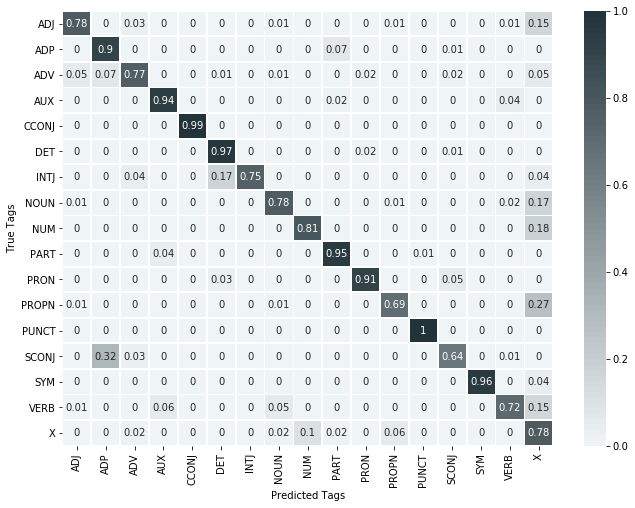

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, vocab_tags):
    
    plt.figure(figsize = (11,8))
    colors = sns.light_palette((220, 50, 20), input="husl", n_colors=80)
    ax = sns.heatmap(np.around(cm, 2),
                    annot=True,
                    linewidths=.8, 
                    cmap=colors)
    ax.set_ylim(bottom = 17, top=0)
    ax.set(xticklabels=vocab_tags)
    ax.set(yticklabels=vocab_tags)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90) 
    plt.ylabel("True Tags")
    plt.xlabel("Predicted Tags")
    plt.show()
    
plot_confusion_matrix(cm, tags_vocab)

## 3.3 <a class="anchor" id="subtask_3_3"></a>
### Study the baseline results (3 points)
By looking at the visualization of normalized confusion matrix, briefly answer the following questions in the cell below:
1. What tags were predicted best? How would you explain it? (1 point)
2. Why some tags (nouns, proper nouns, verbs...) were predicted as 'X' that often? Why 'X' was rarely mistaken with some other classes? (1 point)
3. How many unseen words were in the test corpus? Does it affect performance of the baseline algorithm? (1 point)

In [37]:
x=0
for sentence in test_tags:
    for tag in sentence:
        if tag=='X':
            x+=1
x

49

YOUR ANSWER HERE

1. The PUNCT is the best one. Because it is impossible to be interpreted as other tags.
2. Because they are open classes and also they have lots of inflections. They contains an unlimited amount of words and new words with inflections are coming into them all the time.  Those rarely mistake "X" are almost close classes, which is opposite to open classes. They have limited words and have few inflections.
3. There are 49 unseen words. They have little effect on the performance of the baseline algorithm. Because very few unseen words are interpreted as other tags.

## TASK 4 <a class="anchor" id="task_4"></a>
## HMM POS-tagger
An **HMM** is a probabilistic sequence model. In our case, given a sequence of words, it computes a probability distribution over possible sequences of POS tags and chooses the best tag sequence. If you find the explanations in the notebook lacking, look [here](https://web.stanford.edu/~jurafsky/slp3/A.pdf) for more information.

The *hidden part* of our HMM are tags, because they are some abstract classes that are not directly observed from text sequences. The observed part of our HMM are words these hidden tags produce (yes, we consider that POS tags emit words). 
The components of our HMM will be:
1. **T** - a set of $N$ POS tags

2. **$A$** - a transition probability matrix. Each cell $a_{i,j}$ represents a probability of moving from $tag_i$ to $tag_j$: $P(t_j|t_i)$. We also add the start and end probabilities to this matrix, so it has $N+1$ x $N+1$ dimensions. The row $a_1$ represents the probabilities of each tag to start a sentence. The last column of transition probability matrix A contains the probability of every tag ending a sentence.

<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/A.png">
3. **$B$** - an observation likelihood matrix. Each cell $b_{i,j}$ represents a probability of a $word_i$ being generated out of some $tag_j$: $P(w_i|t_j)$

<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/B.png">

Here is the corpus again, so that it is easy to check that $A$ and $B$ make sense.
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/corpus.png">

### Collect probability matrices A and B

Turns out, we already have everything for our HMM, we just need to turn the counts that we collected previously into maximum likelihood probabilities.

You can do it by normalizing our word-tag and tag-tag matrices across the appropriate axis. For the word-tag matrix, we want the columns to sum to one. And for the tag-tag matrix, we want the rows to sum up to 1. Take a second to make sure you understand why.

Run the cell below to get the $A$ and $B$ matrices.

In [38]:
A = tt_matrix/tt_matrix.sum(axis=1)[:, np.newaxis]
B = wt_matrix/wt_matrix.sum(axis=0)

### Display the tag transition matrix A by running the cell below
Examine that everything looks as you would expect it to.

In [39]:
import pandas as pd
df = pd.DataFrame(data=A, index=["START"]+tags_vocab, columns=tags_vocab+["END"])
df

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SCONJ,SYM,VERB,X,END
START,0.036265,0.084380,0.066840,0.014695,0.019673,0.120171,0.007111,0.083906,0.016355,0.004266,0.216639,0.110690,0.047642,0.066603,0.000000,0.098365,0.006400,0.000000
ADJ,0.061321,0.070189,0.007358,0.002264,0.038302,0.002830,0.000000,0.630755,0.007736,0.024340,0.007358,0.023585,0.096604,0.014717,0.000377,0.010566,0.000755,0.000943
ADP,0.082258,0.018618,0.012290,0.000973,0.006449,0.367121,0.000000,0.183865,0.048795,0.001339,0.103431,0.133974,0.022268,0.005111,0.000487,0.010465,0.001095,0.001460
ADV,0.147519,0.128824,0.086676,0.025833,0.021074,0.046567,0.000000,0.018015,0.030931,0.012916,0.046567,0.004079,0.181169,0.031271,0.001360,0.214140,0.000680,0.002379
AUX,0.100907,0.021171,0.133352,0.068463,0.002475,0.103107,0.000275,0.016497,0.009073,0.106406,0.041793,0.009073,0.012098,0.004399,0.000000,0.370910,0.000000,0.000000
CCONJ,0.112514,0.049369,0.082281,0.028320,0.000383,0.088021,0.000000,0.193647,0.022962,0.009185,0.107539,0.082281,0.016839,0.018752,0.001531,0.185610,0.000765,0.000000
DET,0.246703,0.000000,0.017536,0.000150,0.000000,0.000150,0.000000,0.583034,0.013339,0.000000,0.000749,0.109562,0.007644,0.000000,0.000450,0.019784,0.000899,0.000000
INTJ,0.000000,0.023810,0.000000,0.011905,0.000000,0.000000,0.083333,0.000000,0.011905,0.000000,0.083333,0.023810,0.738095,0.000000,0.000000,0.023810,0.000000,0.000000
NOUN,0.010392,0.241500,0.021060,0.068341,0.069167,0.005368,0.000000,0.099174,0.004680,0.028424,0.031659,0.010599,0.297729,0.025465,0.001445,0.071645,0.000482,0.012870
NUM,0.028589,0.108142,0.009323,0.005594,0.029211,0.004972,0.000000,0.297700,0.018024,0.004351,0.014916,0.034183,0.384711,0.004351,0.010566,0.018024,0.000000,0.027346


### HMM decoding

The aim of an HMM decoding is to choose the tag sequence $t^n_1$ that will be the most probable given the observation sequence of $n$ words $w^n_1$: $\underset{t^n_1}{\arg\max}P(t^n_1|w^n_1)$

Using Bayes' rule, we can very conveniently flip this into: $\underset{t^n_1}{\arg\max}\frac{P(w^n_1|t^n_1)P(t^n_1)}{P(w^n_1)}$. You can also notice, that we don't need denominator for maximizing the tag sequence probability. Thus:

*best tag sequence* $= \underset{t^n_1}{\arg\max}P(w^n_1|t^n_1)P(t^n_1)$

Now we can simplify it even further by assuming:

1. the probability of a particular tag depends only on the previous tag
2. the probability of an observed word depends only on the tag that produced this word

*best tag sequence* $= \underset{t^n_1}{\arg\max}\displaystyle\prod_{i=1}^{n}P(w_i|t_i)P(t_i|t_{i-1})$

Lucky us, we've already collected probabilities $P(w_i|t_i)$ in the matrix B, and $P(t_i|t_{i-1})$ in the matrix A! Now we need to come up with how to ${\arg\max}$ those.

### Viterbi algorithm

The Viterbi algorithm is a dynamic programming algorithm for finding the most likely sequence of hidden states. In our case, its output is the most probable sequence of POS tags and its probability for some word sequence.

* STEP 1: get a sequence you want to tag:
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/seq.png" width="200">
* STEP 2: create a path probability matrix $V$ with the shape (number of tags, number of words to tag). 
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/table1.png" width="350">
Each cell $V_{j,i}$ represents the probability that the HMM has tag $j$ after seeing $i$ words and passing through the most probable tag sequence $t_1,t_2...t_{i-1}$.
This most probable path of tags so far is represented as maximum over all previous tag sequences. The probabilities of $V_{i,j}$ are computed by starting from the most probable of the extensions of the paths that lead to the current cell.

* STEP 3: creat a backpointer table $P$ of shape (number of tags, number of words in a sequence). You can think of it as a table where to write an index of the most probable tag that generated the word before the word we want to tag now. You can skip the first word, since the tag before it was just the beggining of the sentence. But we also need to add the imagined "END" word (tagged with dummy "END" POS tag), to use the knowledge of what tags are most likely to end a sentence.
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/table2.png">
* STEP 4: start filling the first column of $V$. Each cell $V_{j,1}$ contains a probability of a tag $j$ being the starting tag of the sentence $P(t_j|start)$ multiplied by the probability of the first word in the sequence being generated by this tag $P(word_1|t_j)$. $V_{j,1} = P(t_j|start)P(word_1|t_j)$
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/table1_1.png">
* STEP 5: move on to fill in the second column of $V$. Each cell $V_{j,2}$ contains a product of two probabilities:
    1. the maximum from the products of every value in the previous column of $V$ and every transition probability to the tag $j$. This value keeps balance between what is likely according to the tag language model and what we have seen before.
    <img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/max.png">
    2. the probability of the second word in the sequence being generated by the tag $j$ $P(word_2|t_j)$
    <img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/max_and_wt.png" width="250">
* STEP 6: save the backpointer to the index of the most probable tag of the previous word (the index of the maximum from the products of every value in the previous column of $V$ and every transition probability to the tag $j$. In this example, we say 'right' as 'ADJ' came from the previous word marked as 'ADJ'
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/backpointer.png">
* STEP 7: compute the rest of the table $V$ as in STEP 5, don't forget to save backpointers as in STEP 6.
* STEP 8: compute the final output probabilities of your tag paths by multiplying the last column of V by probability of each tag to end a sentence. 
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/final.png">
* STEP 9: add the last backpointer by chosing the most probable last tag from STEP 8.
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/last_pointer.png">
* STEP 10: trace back the indices in your backpointer table P, starting with the one that was output by STEP 9. In the example below, we see that the END was preceded by hand as NOUN, we go to the step before, and look what hand as NOUN was preceded by. It was right as ADJ. and so on until the start of the sentence.
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/path.png">
* STEP 11: return the most probable tag sequence from the backtraced path.
<img src= "../../../coursedata/notebook_illustrations/04-pos-tagging/tags_predicted.png">

## 4.1 <a class="anchor" id="subtask_4_1"></a>
### Create Viterbi algorithm (5 points)

You're going to write several functions, that we then chain together. It is easier to do some parts of the algorithm in different functions for debugging purposes.
* 1 Fill in the first column of $V$.
* 2 Fill in the rest of $V$ and keep backpointers $P$.
* 3 Backtrace the most probable tag sequence from $P$.


* Note 1: to avoid numerical underflow, use log probabilities.
* Note 2: log probabilities should be summed (not multiplied as in our formulas)
* Note 3: when you encounter an unseen word, cheat and don't include the observation probabilities (rely only on the tag probabilities) 

### 4.1.1 <a class="anchor" id="subtask_4_1_1"></a>
#### First column of V (1 point)
Look at steps 4 and 5 and complete the `viterbi_first_column()` function. Note that we don't keep any backpointers for the first word, because we know that before the first word we could only have an imaginary word "START" with and imaginary tag "START"

In [40]:
def viterbi_first_column(A, B, word_sequence, tags_vocab, words_vocab):
    """
    Fills in the first column of a path probability matrix V (Steps 4-5)
    If the first word in a sequence was not seen during training, 
    use only pribabilities from A matrix. 
    Transform all probabilities into log with numpy.log()
    If something used to have a 0 probability, it shoud have a -inf probability now.
    
    
    Paramters
    --------
    A : a numpy array 
        transition probability matrix for POS tags
    B : a numpy array 
        an observation likelihood matrix
    word_sequence : a list of strings
        a word sequence to tag
    tags_vocab : a list of strings
        a list of UD tag labels
    words_vocab : a list of strings
        a list of word types seen during training
        
    Returns
    -------
    path_probability_matrix - a numpy array
        a path probability matrix with first column filled in,
        other columns have zeros in them
    """
    
    # a template for a the V matrix with 0 in every cell
    path_probability_matrix = np.zeros((len(tags_vocab), len(word_sequence)))
    
    # YOUR CODE HERE
    if word_sequence[0] not in words_vocab:
        start_word_obs_pro=np.ones(len(tags_vocab))
    else:
        start_word_index=words_vocab.index(word_sequence[0])
        start_word_obs_pro=B[start_word_index]
    
    path_probability_matrix[:,0]=np.log(A[0,:-1]*start_word_obs_pro)
    return path_probability_matrix

In [41]:
from numpy.testing import assert_allclose

dummy_A = np.array([[3/4,1/4,0],
                    [1/4,3/4,0],
                    [0,0,1.]])
dummy_B = np.array([[0,1],
                    [3/4,0],
                    [1/4, 0]])
dummy_test = ['red','right','hand']
dummy_tags_vocab = ["ADJ", "NOUN"]
dummy_words_vocab = ['hand','red','right']



# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that the output is a numpy array
assert_equal(type(viterbi_first_column(dummy_A, 
                                       dummy_B, 
                                       dummy_test, 
                                       dummy_tags_vocab, 
                                       dummy_words_vocab)),np.ndarray)

assert_equal(viterbi_first_column(dummy_A, 
                                   dummy_B, 
                                   dummy_test, 
                                   dummy_tags_vocab, 
                                   dummy_words_vocab).shape, (len(dummy_tags_vocab), len(dummy_test)))


# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check the function is giving out the right probabilities
assert_almost_equal(viterbi_first_column(dummy_A,
                                          dummy_B,
                                          dummy_test,
                                          dummy_tags_vocab,
                                          dummy_words_vocab)[0][0], np.log(0.562), 2)

# checking that the function is working with unknown words
dummy_test2 = ['leg','right','red']
assert_equal(viterbi_first_column(dummy_A,
                                  dummy_B, 
                                  dummy_test2, 
                                  dummy_tags_vocab,
                                  dummy_words_vocab)[0][0], np.log(dummy_A[0][0]))

assert_equal(viterbi_first_column(dummy_A,
                                  dummy_B, 
                                  dummy_test2, 
                                  dummy_tags_vocab,
                                  dummy_words_vocab)[1][0], np.log(dummy_A[0][1]))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


In [42]:
assert_almost_equal(viterbi_first_column(dummy_A,dummy_B,
dummy_test,
dummy_tags_vocab,
dummy_words_vocab)[1][0], np.log(0), 2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [43]:
dummy_A2 = np.array([[0,1,0],  
[1/4,3/4,0],
[0,2/4,2/4]])
assert_equal(viterbi_first_column(dummy_A2,
                 dummy_B, 
                 dummy_test2, 
                 dummy_tags_vocab,
                 dummy_words_vocab)[0][0],np.log(dummy_A2[0][0]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


### 4.1.2 <a class="anchor" id="subtask_4_1_2"></a>
#### The rest of V and P
Steps 6-9

Now fill in the rest of $V$ and the whole $P$.
For the last backpointer, just fill in the whole last column of $P$ with the most probable tag for the last word.

In [44]:
def viterbi_rest(path_probability_matrix, A, B, word_sequence, tags_vocab, words_vocab):
    """ Fills in V and P matrices
    
     
    Paramters
    --------
    path_probability_matrix: a numpy array
        a path probability matrix with first column filled in
        the result of viterbi_first_column()
    A : a numpy array 
        transition probability matrix for POS tags
    B : a numpy array 
        an observation likelihood matrix
    word_sequence : a list of strings
        a word sequence to tag
    tags_vocab : a list of strings
        a list of UD tag labels
    words_vocab : a list of strings
        a list of word types seen during training
      
    Returns
    -------
    path_probability_matrix : a numpy array
        matrix V
    backpointer_table : a numpy array
        a matrix P with backpointers
    """
    
    # a template for a backpointer table with -1 in every cell
    backpointer_table = np.full((len(tags_vocab), len(word_sequence)), -1) 
    
    # FILL IN THE REST OF THE path_probability_matrix
    # DON'T FORGET TO KEEP BACKPOINTERS
    

        
    # YOUR CODE HERE  

    for i in range(1,len(word_sequence)):
        if word_sequence[i] not in words_vocab:
            word_obs_pro=np.ones(len(tags_vocab))
        else:
            word_index=words_vocab.index(word_sequence[i])
            word_obs_pro=B[word_index]
            
        
        for j in range(0,len(tags_vocab)):
            temp=-np.inf
            all_prob=path_probability_matrix[:,i-1]+np.log(A[1:,j])+np.log(word_obs_pro[j])
            path_probability_matrix[j,i]=np.max(all_prob)
            backpointer_table[j,i-1]=np.argmax(all_prob)

    backpointer_table[:,-1]=np.argmax(path_probability_matrix[:,-1]+np.log(A[1:,-1]))

    return path_probability_matrix, backpointer_table

In [45]:
dummy_A = np.array([[3/4,1/4,0],
                    [1/4,3/4,0],
                    [0,0,1.]])

dummy_B = np.array([[0,1],
                    [3/4,0],
                    [1/4, 0]])

dummy_test = ['red','right','hand']
dummy_tags_vocab = ["ADJ", "NOUN"]
dummy_words_vocab = ['hand','red','right']
dummy_V = np.array([[-0.57536414,0.,0.],
                    [np.NINF,0.,0.]])

correct_P = np.array([[0, 0, 1],
                      [0, 0, 1]])



# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that the output is a numpy array
assert_equal(type(viterbi_rest(dummy_V,
                               dummy_A, 
                               dummy_B, 
                               dummy_test, 
                               dummy_tags_vocab, 
                               dummy_words_vocab)[0]),np.ndarray)

assert_equal(type(viterbi_rest(dummy_V,
                               dummy_A, 
                               dummy_B, 
                               dummy_test, 
                               dummy_tags_vocab, 
                               dummy_words_vocab)[1]),np.ndarray)

assert_equal(viterbi_rest(dummy_V,
                          dummy_A, 
                          dummy_B,
                          dummy_test,
                          dummy_tags_vocab,
                          dummy_words_vocab)[0].shape, (len(dummy_tags_vocab), len(dummy_test)))
             
assert_equal(viterbi_rest(dummy_V,
                          dummy_A, 
                          dummy_B, 
                          dummy_test, 
                          dummy_tags_vocab, 
                          dummy_words_vocab)[1].shape, (len(dummy_tags_vocab), len(dummy_test)))



# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
# check the function is giving out the right probabilities
assert_almost_equal(viterbi_rest(dummy_V,
                                 dummy_A,
                                 dummy_B,
                                 dummy_test,
                                 dummy_tags_vocab,
                                 dummy_words_vocab)[0][0][1], np.log(0.035), 2)

# check the function is giving out the right backpointers
assert_array_equal(viterbi_rest(dummy_V,
                                 dummy_A,
                                 dummy_B,
                                 dummy_test,
                                 dummy_tags_vocab,
                                 dummy_words_vocab)[1], correct_P)

# checking that the function is working correctly with unknown words
dummy_test2 = ['red','right','leg']
dummy_V2 = np.array([[-0.28768207,  0.        ,  0.        ],
                     [-1.38629436,  0.        ,  0.        ]])

correct_V2 = np.array([[-0.28768207, -3.06027079, -4.44656515],
                       [-1.38629436,        np.NINF, -3.34795286]])

correct_P2 = np.array([[0, 0, 1],
                       [0, 0, 1]])

assert_almost_equal(viterbi_rest(dummy_V2,
                                  dummy_A,
                                  dummy_B, 
                                  dummy_test2, 
                                  dummy_tags_vocab,
                                  dummy_words_vocab)[0], correct_V2, 3)

assert_array_equal(viterbi_rest(dummy_V2,
                                  dummy_A,
                                  dummy_B, 
                                  dummy_test2, 
                                  dummy_tags_vocab,
                                  dummy_words_vocab)[1], correct_P2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


In [46]:
test_A = np.array([[3/4,1/4,0],
                    [1/4,3/4,0],
                    [0,0,1.]])

test_B = np.array([[0,1],
                    [3/4,0],
                    [1/4, 0]])
test_tags_vocab = dummy_tags_vocab
test_words_vocab = dummy_words_vocab

In [47]:
test3 = ['hand','leg','red']
dummy_V3 = np.array([[       np.NINF,  0.        ,  0.        ],
                     [-1.02961942,  0.        ,  0.        ]])
dummy_P3_correct = np.array([[0, 0, 0],
                            [0, 0, 0]])
dummy_V3_correct = np.array([[    np.NINF,np.NINF,np.NINF],
                            [-1.02961942,np.NINF,np.NINF]])
assert_almost_equal(viterbi_rest(dummy_V3,
                                  test_A,
                                  test_B, 
                                  test3, 
                                  test_tags_vocab,
                                  test_words_vocab)[0], dummy_V3_correct, 3)
assert_almost_equal(viterbi_rest(dummy_V3,
                                  test_A,
                                  test_B, 
                                  test3, 
                                  test_tags_vocab,
                                  test_words_vocab)[1], dummy_P3_correct, 3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


### 4.1.3 <a class="anchor" id="subtask_4_2_3"></a>
#### Traceback the Tag sequence
Steps 10-11

Take the backpointer matrix and trace the most probable tag sequence.

In [48]:
def trace_backpointers(backpointer_table, tags_vocab):
    """ Traces tag sequence from a backpointer table P
    
    Parameters
    ----------
    backpointer_table : a numpy array
        a matrix P with backpointers
    tags_vocab : a list of strings
        a list of UD tag labels
        
    Returns
    -------
    best_path : a list of strings
        most probable tags for the words in a test sequence
    """
    
    best_path = []
    # YOUR CODE HERE
    pointer=0
    for i in range(backpointer_table.shape[1]-1,-1,-1):
        pointer=backpointer_table[pointer,i]
        best_path.insert(0,tags_vocab[pointer])
    return best_path

In [49]:
dummy_A = np.array([[3/4,1/4,0],
                    [1/4,3/4,0],
                    [0,0,1.]])

dummy_B = np.array([[0,1],
                    [3/4,0],
                    [1/4, 0]])

dummy_test = ['red','right','hand']
dummy_tags_vocab = ["ADJ", "NOUN"]
dummy_words_vocab = ['hand','red','right']

correct_dummy_tags = ['ADJ', 'ADJ', 'NOUN']
correct_P = np.array([[0, 0, 1],
                      [0, 0, 1]])

# CHECKING THE GENERAL PROPERTIES OF THE OUTPUT
# check that we get a list of strings
assert_equal(type(trace_backpointers(correct_P, dummy_tags_vocab)), list)
assert_equal(type(trace_backpointers(correct_P, dummy_tags_vocab)[0]), str)
# check the length
assert_equal(len(trace_backpointers(correct_P, dummy_tags_vocab)), correct_P.shape[1])

# CHECKING THAT THE FUNCTION IS WORKING AS IT SHOULD
assert_equal(trace_backpointers(correct_P, dummy_tags_vocab),correct_dummy_tags)



In [50]:
new_dummy_tags_vocab = ["tag1", "tag2","tag3","tag4"]
new_dummy_backpointer = np.array([[1, 3, 1, 2, 1],
                [1, 1, 1, 2, 1],
                [1, 2, 0, 2, 1],
                [0, 0, 1, 2, 1]])
new_correct_tags = ['tag1', 'tag4', 'tag1', 'tag3', 'tag2']
assert_equal(trace_backpointers(new_dummy_backpointer, new_dummy_tags_vocab), new_correct_tags)

### Evaluate HMM
Run the cell below to get an accuracy score for your HMM tagger and to plot the confusion matrix. Your accuracy should be better than baseline. Note that the computations take some time.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log


90.17006454256736


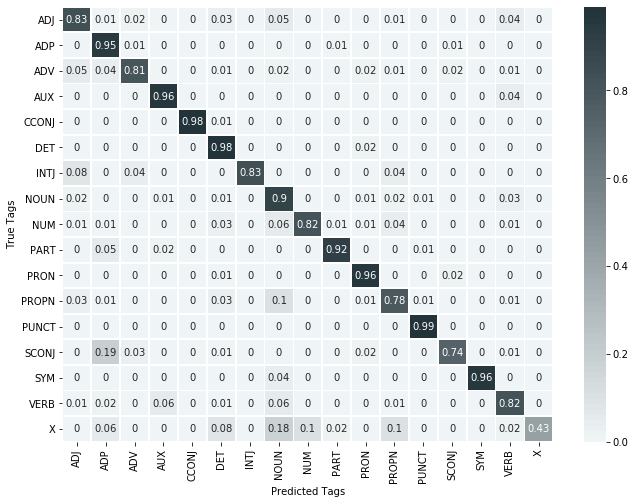

In [51]:
hmm_tags_predicted = []
for i in range(len(test_words)):
    V = viterbi_first_column(A, B, test_words[i], tags_vocab, words_vocab)
    _, P = viterbi_rest(V, A, B, test_words[i], tags_vocab, words_vocab)
    hmm_tags_predicted.append(trace_backpointers(P, tags_vocab))
    
print(accuracy(test_tags, hmm_tags_predicted))

cm_hmm = create_confusion_matrix(test_tags, hmm_tags_predicted)
plot_confusion_matrix(cm_hmm, tags_vocab)

## 4.2  <a class="anchor" id="subtask_4_2"></a>
### Compare HMM and Baseline (1 point)

Briefly decribe in the cell below the differences in the performance of our HMM and the baseline models. What can be done to further improve the HMM model?

YOUR ANSWER HERE

The baseline labels the words with the most frequent tags without consider the context.

The HMM will take care of the former word to decide the probability of the current word and then form a probability chain. It consider frequency and context at the same time.



## Checklist before submission <a class="anchor" id="checklist"></a>
### 1
To make sure that you didn't forget to import some package or to name some variable, press **Kernel -> Restart** and then **Cell -> Run All**. This way your code will be run exactly in the same order as during the autograding.
### 2
Click the **Validate** button in the upper menu to check that you haven't missed anything. Be careful now (Viterbi takes time, you might need to validate through the terminal).
### 3
To submit the notebook, click on the **jupyterhub** logo in the upper left part of the window, choose the **Assignments** folder, and press **submit**. You can submit multiple times, only the last one counts.
### 4
Please fill in the feedback form in the [Assignment](https://mycourses.aalto.fi/mod/questionnaire/view.php?id=701856&forceview=1) section of Mycoures.